In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import flax
except ImportError:
    %pip install -q flax

try:
    import optax
except ImportError:
    %pip install -q optax

(transforms)=

# Kernel Transforms

`tinygp` is designed to make it easy to implement new kernels (see {ref}`kernels` for an example), but a particular set of customizations that `tinygp` supports with a high-level interface are coordinate transforms.
The basic idea here is that you may want to pass your input coordinates through a linear or non-linear transformation before evaluating one of the standard kernels in that transformed space.
This is particularly useful for multivariate inputs where, for example, you may want to capture the different units, or prior covariances between dimensions.

(transforms-dkl)=

## Example: Deep kernel lerning

The [Deep Kernel Learning](https://arxiv.org/abs/1511.02222) model is an example of a more complicated kernel transform, and since `tinygp` integrates well with libraries like `flax` (see {ref}`modeling`) the implementation of such a model is fairly straightforward.
To demonstrate, let's start by sampling a simulated dataset from a step function, a model that a GP would typically struggle to model:

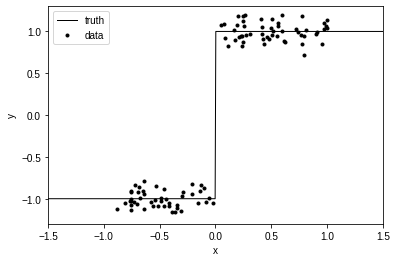

In [2]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(567)

noise = 0.1

x = np.sort(random.uniform(-1, 1, 100))
y = 2 * (x > 0) - 1 + random.normal(0.0, noise, len(x))
t = np.linspace(-1.5, 1.5, 500)

plt.plot(t, 2 * (t > 0) - 1, "k", lw=1, label="truth")
plt.plot(x, y, ".k", label="data")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

Then we will fit this model using a model similar to the one described in {ref}`modeling-flax`, except our kernel will include a custom {class}`tinygp.kernels.Transform` that will pass the input coordinates through a (small) neural network before passing them into a {class}`tinygp.kernels.Matern32` kernel.
Otherwise, the model and optimization procedure are similar to the ones used in {ref}`modeling-flax`.

We compare the performance of the Deep Matern-3/2 kernel (Matern32 kernel with custom neural network transform) with a straight Matern32 Kernel (without transform) at the discontinuity (sudden jump/fall) region in the data.

Deep Kernel learning is an end-to-end learning where the data transform parameters (neural network parameters) and base kernel hyperparameters are learnt simultaneously.

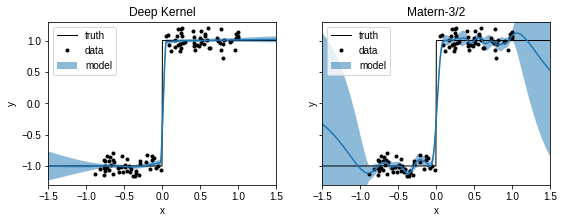

In [3]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
from tinygp import kernels, transforms, GaussianProcess


class Matern32Loss(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # Set up a typical Matern-3/2 kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        base_kernel = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))

        # Evaluate and return the GP negative log likelihood as usual
        gp = GaussianProcess(
            base_kernel, x[:, None], diag=noise ** 2 + jnp.exp(2 * log_jitter)
        )
        log_prob, gp_cond = gp.condition(y, t[:, None])
        return -log_prob, (gp_cond.loc, gp_cond.variance)


# Define a small neural network used to non-linearly transform the input data in our model
class Transformer(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=15)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x


class DeepLoss(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # Set up a typical Matern-3/2 kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        base_kernel = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))

        # Define a custom transform to pass the input coordinates through our `Transformer`
        # network from above
        transform = Transformer()
        kernel = transforms.Transform(transform, base_kernel)

        # Evaluate and return the GP negative log likelihood as usual with the transformed features
        gp = GaussianProcess(
            kernel, x[:, None], diag=noise ** 2 + jnp.exp(2 * log_jitter)
        )
        log_prob, gp_cond = gp.condition(y, t[:, None])
        return (
            -log_prob,
            (gp_cond.loc, gp_cond.variance),
            (transform(x[:, None]), transform(t[:, None])),
        )


# Define and train the model
def loss_func(model):
    def loss(params):
        return model.apply(params, x, y, t)[0]

    return loss


models_list, params_list = [], []
loss_vals = {}
# Plot the results and compare to the true model
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(9, 3))
for it, (model_name, model) in enumerate(
    zip(
        ["Deep Kernel", "Matern-3/2"],
        [DeepLoss(), Matern32Loss()],
    )
):
    loss_vals[it] = []
    params = model.init(jax.random.PRNGKey(1234), x, y, t)
    tx = optax.sgd(learning_rate=1e-4)
    opt_state = tx.init(params)

    loss = loss_func(model)
    loss_grad_fn = jax.jit(jax.value_and_grad(loss))
    for i in range(1000):
        loss_val, grads = loss_grad_fn(params)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        loss_vals[it].append(loss_val)

    mu, var = model.apply(params, x, y, t)[1]
    ax[it].plot(t, 2 * (t > 0) - 1, "k", lw=1, label="truth")
    ax[it].plot(x, y, ".k", label="data")
    ax[it].plot(t, mu)
    ax[it].fill_between(
        t, mu + np.sqrt(var), mu - np.sqrt(var), alpha=0.5, label="model"
    )
    ax[it].set_xlim(-1.5, 1.5)
    ax[it].set_ylim(-1.3, 1.3)
    ax[it].set_xlabel("x")
    ax[it].set_ylabel("y")
    ax[it].set_title(model_name)
    _ = ax[it].legend()

    models_list.append(model)
    params_list.append(params)

The straight Matern-3/2 kernel suffers from over-smoothing at the discontinuity region, and there are large error bars near the train points. But the Deep Kernel fits better on this dataset with smaller errors and handles the sudden jump in the data adequately.

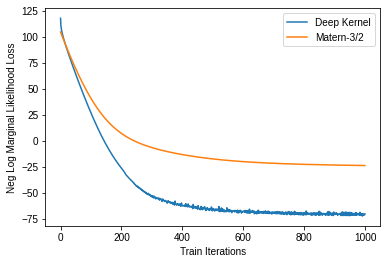

In [4]:
fig = plt.plot()
plt.plot(loss_vals[0], label="Deep Kernel")
plt.plot(loss_vals[1], label="Matern-3/2")
plt.ylabel("Neg Log Marginal Likelihood Loss")
plt.xlabel("Train Iterations")
_ = plt.legend()

From the training loss (Negative Log Marginal Likelihood), we observe that the learned Deep Kernel hyperparameters are more likely than the learned straight Matern-3/2 hyperparameters for the Gaussian fit on data.

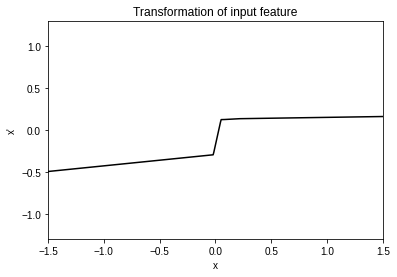

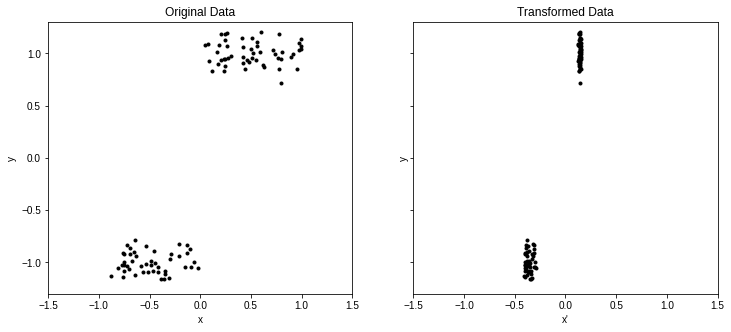

In [5]:
x_transform, t_transform = models_list[0].apply(params_list[0], x, y, t)[2]

fig = plt.figure()
plt.plot(t, t_transform, "k")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("x'")
plt.title("Transformation of input feature")

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))


for it, (fig_title, feature_input, x_label) in enumerate(
    zip(["Original Data", "Transformed Data"], [x, x_transform], ["x", "x'"])
):
    ax[it].plot(feature_input, y, ".k")
    ax[it].set_xlim(-1.5, 1.5)
    ax[it].set_ylim(-1.3, 1.3)
    ax[it].set_title(fig_title)
    ax[it].set_xlabel(x_label)
    ax[it].set_ylabel("y")

The neural network transforms the input feature into a step function like data (as shown in the figures above) before feeding to the base kernel, making it better suited than the straight base Kernel for this data.

We fit a straight Matern-3/2 kernel on the transformed data in the following step.

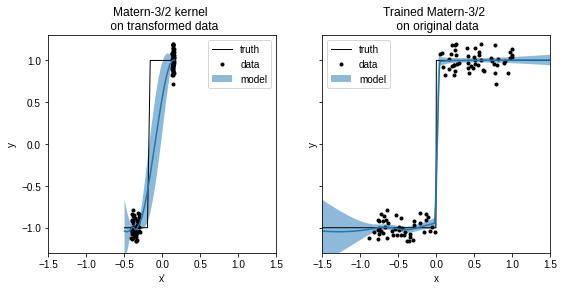

In [6]:
model = Matern32Loss()
params = model.init(jax.random.PRNGKey(1234), x_transform, y, t_transform)
tx = optax.sgd(learning_rate=1e-4)
opt_state = tx.init(params)

loss = loss_func(model)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))
for i in range(1000):
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


mu, var = model.apply(params, x_transform, y, t_transform)[1]
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))
for it, (input_data, input_line, x_label, fig_title) in enumerate(
    zip(
        [x_transform, x],
        [t_transform, t],
        ["x'", "x"],
        [
            "Matern-3/2 kernel \n on transformed data",
            "Trained Matern-3/2 \n on original data",
        ],
    )
):
    ax[it].plot(input_line, 2 * (t > 0) - 1, "k", lw=1, label="truth")
    ax[it].plot(input_data, y, ".k", label="data")
    ax[it].plot(input_line, mu)
    ax[it].fill_between(
        input_line.squeeze(),
        mu + np.sqrt(var),
        mu - np.sqrt(var),
        alpha=0.5,
        label="model",
    )
    ax[it].set_xlim(-1.5, 1.5)
    ax[it].set_ylim(-1.3, 1.3)
    ax[it].set_xlabel(x_label)
    ax[it].set_ylabel("y")
    ax[it].set_title(fig_title)
    ax[it].legend()

We can observe that the straight Matern-3/2 kernel fit on transformed data is equivalent to Deep Kernel fit on the original data. So the transformation is the key to understanding why Deep Kernel performs better in this scenario.

Deep Kernel works better at the discontinuity region as the transformation has contracted the input feature values close to two input values like a step function. Now the Matern-32 kernel fits around these two concentrated input values (like two high weighted points). The predictions get also contracted around the two corresponding output values (-1 and +1) in the gaussian fit as the transformed inputs were concentrated.